<a href="https://colab.research.google.com/github/Amal-Baby-Mathews/Mega_ML/blob/main/LSTM%7CShap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install shap
!pip install pynput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.9 MB/s eta 0:00:00
  Created wheel for evdev: filename=evdev-1.7.0-cp310-cp310-linux_x86_64.whl size=92536 sha256=1a2c9274ea82a5e74e9cacbdf4741dee72bb9d18127b6dcd35dc1b0ed0c4d4c2
  Stored in directory: /root/.cache/pip/wheels/16/c9/19/2c0af606c704d962276592b03175d1796077199329e2777ec0
Successfully built evdev


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from shap import KernelExplainer, summary_plot,sample

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset.csv')
data = data.dropna()
X = data.drop('be_system_abort_shutdown', axis=1)
y = data['be_system_abort_shutdown']

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [6]:
print(X.head(3))
print(y.head(3))

   be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
0                   20.430000   0.727123          97.119904   
1                   20.440001   0.727123          97.119904   
2                   20.440001   0.727123          97.119904   

   al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
0                    80.125                         6.941713  
1                    80.125                         6.941651  
2                    80.125                         6.973380  
0    0
1    0
2    0
Name: be_system_abort_shutdown, dtype: int64


In [7]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, callbacks=[early_stop])


Epoch 1/5
11589/11589 [==============================] - 65s 5ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1300e-07 - val_accuracy: 1.0000
Epoch 2/5
11589/11589 [==============================] - 54s 5ms/step - loss: 9.3544e-08 - accuracy: 1.0000 - val_loss: 3.8265e-10 - val_accuracy: 1.0000
Epoch 3/5
11589/11589 [==============================] - 53s 5ms/step - loss: 1.4598e-09 - accuracy: 1.0000 - val_loss: 4.7875e-11 - val_accuracy: 1.0000
Epoch 4/5
11589/11589 [==============================] - 54s 5ms/step - loss: 4.5834e-10 - accuracy: 1.0000 - val_loss: 2.2175e-11 - val_accuracy: 1.0000
Epoch 5/5
11589/11589 [==============================] - 55s 5ms/step - loss: 2.7430e-10 - accuracy: 1.0000 - val_loss: 1.3943e-11 - val_accuracy: 1.0000


In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


2898/2898 [==============================] - 6s 2ms/step - loss: 1.3943e-11 - accuracy: 1.0000
Test accuracy: 1.0


In [9]:
#X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
explainer = KernelExplainer(model.predict, data=X_train)



11589/11589 [==============================] - 22s 2ms/step


In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

# Create a separate model for SHAP
input_layer = Input(shape=(X_train.shape[1] * X_train.shape[2],))
reshaped = Reshape((X_train.shape[1], X_train.shape[2]))(input_layer)
output = model_lstm(reshaped)
model_shap = Model(inputs=input_layer, outputs=output)

# Compile and train the model
# ... (code omitted for brevity)

# Prepare the data for feature importance analysis
background_data = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
background_data_summary = sample(background_data, 1)  # Use 1000 representative samples
explainer = KernelExplainer(model_shap.predict, background_data_summary)

# Downsample X_test to 5000 samples
X_test_downsampled = resample(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2]),
                              replace=False,
                              n_samples=500,
                              random_state=42)

# Calculate feature importance using SHAP
shap_values = explainer.shap_values(X_test_downsampled)
#summary_plot(shap_values, X.columns)


1/1 [==============================] - 1s 990ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


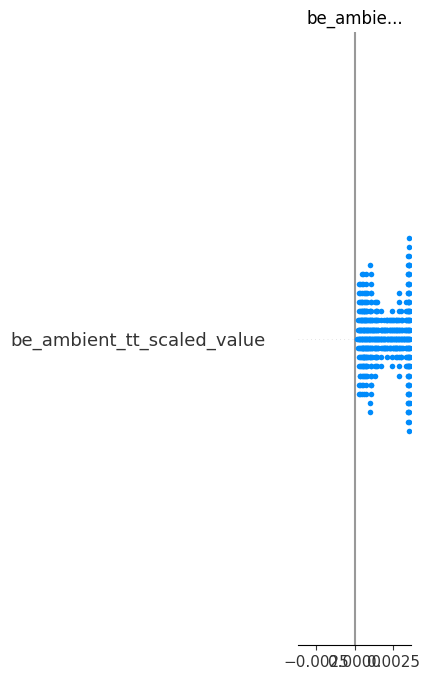

In [12]:
summary_plot(shap_values, X.columns)

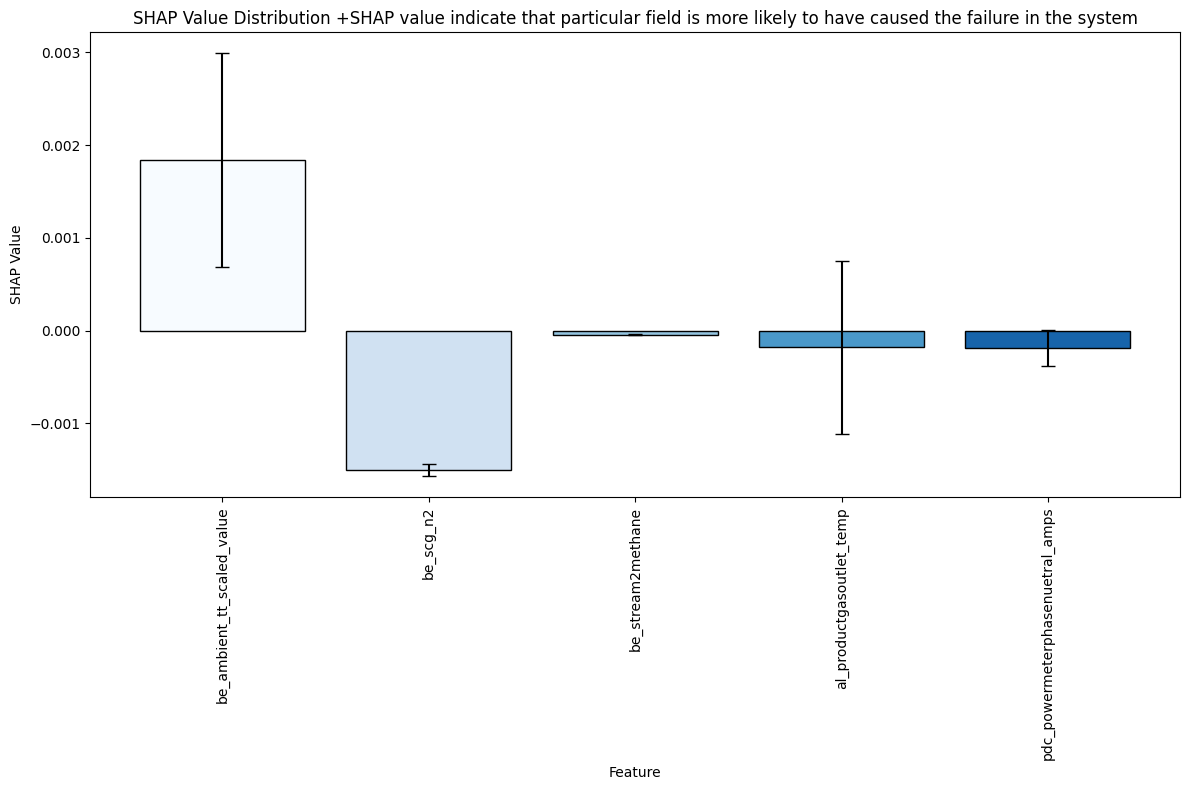

In [26]:
import matplotlib.pyplot as plt
#import numpy as np  # Ensure numpy is imported for mean and std calculations

feature_names = X.columns

# Create a color map for better visualization
cmap = plt.get_cmap('Blues')

# Calculate SHAP value statistics (corrected for multi-dimensional arrays)
shap_values_mean = np.mean(shap_values, axis=0)
shap_values_std = np.std(shap_values, axis=0)

# Plot SHAP values (corrected color assignment using a loop)
plt.figure(figsize=(12, 8))
for i in range(len(feature_names)):
    color = cmap(i / len(feature_names))  # Assign varying colors for better visualization
    plt.bar(i, shap_values_mean[i], yerr=shap_values_std[i], capsize=5, color=color, edgecolor='black')

plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('SHAP Value')
plt.title('SHAP Value Distribution +SHAP value indicate that particular field is more likely to have caused the failure in the system')
plt.tight_layout()
plt.show()

In [13]:
def predict_failure(data):
    data_scaled = scaler.transform(data)
    data_reshaped = data_scaled.reshape((1, 1, data_scaled.shape[1]))
    prediction = model.predict(data_reshaped)
    failure_probability = prediction[0][0]
    return failure_probability

# Set a threshold for failure prediction
threshold = 0.7

In [14]:
def get_latest_system_data():
    # Get the first sample from the test data
    latest_data = X_test[0].reshape(1, -1)

    # Simulate new data by adding random noise
    noise = np.random.normal(0, 0.1, size=latest_data.shape)
    latest_data += noise

    # Ensure the data is within the valid range (0 to 1)
    latest_data = np.clip(latest_data, 0, 1)

    return latest_data

In [24]:


while True:
  # Get the latest system data
  latest_data = get_latest_system_data()

  # Predict failure probability
  failure_prob = predict_failure(latest_data)

  if failure_prob > threshold:
      print(f'Potential system failure detected! Probability: {failure_prob:.2f}')
      print('Field variations contributing to the failure:')
      for feature, importance in zip(X.columns, shap_values[0]):
          if importance > 0:
              print(f'- {feature}: Importance = {importance:.2f}')
  else:
      print('System operating normally.')

ImportError: this platform is not supported: ('failed to acquire X connection: Bad display name ""', DisplayNameError(''))

Try one of the following resolutions:

 * Please make sure that you have an X server running, and that the DISPLAY environment variable is set correctly